## 4.0 Bussiness Metrics Calculation

* **Objective:** Calculate these metrics:
-  Total revenue
- Total number of customers
- Total number of transactions
- Average order value (AOV)
- Average revenue per customer


    **Time-based Metrics:**
 - Monthly revenue trend
 - Monthly customer acquisition (first-time buyers per month)
 - Month-over-month growth rates


In [1]:
import pandas as pd 
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv("../data/processed/ecommerce_clean.csv")

In [3]:
# Ensuring the date columns are on datetime formate

date_cols = [col for col in df.columns if 'date' in col or 'timestamp' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

total_revenue = df['revenue'].sum()
total_customers = df['customer_unique_id'].nunique()
total_transactions = df['order_id'].nunique()
aov = total_revenue / total_transactions
avg_rev_per_customer = total_revenue / total_customers

print(f"Total Revenue: R${total_revenue:,.2f}")
print(f"Total Customers: {total_customers:,}")
print(f"Total Transactions: {total_transactions:,}")
print(f"AOV: {aov:}")
print(f"Average Revenue Per Custommers: {avg_rev_per_customer:,}")



Total Revenue: R$15,216,419.91
Total Customers: 92,079
Total Transactions: 95,127
AOV: 159.9590012299347
Average Revenue Per Custommers: 165.25396572508387


* **Insights** 
* The total transactions to cutomers is low meaning low customer repeat rate (Low retention business model)

* The AOV is mid to low. This indicates customers are typically buying single items or low-cost bundles. 

* Avg Revenue Per Customer (R$165.25) is only marginally higer than AOV (R$160.00). This confirms the conclusion above. The revenue model is almost entirely by first purchase value rather than sustained, frequent purchasing. 

## Time-based Metrics

In [4]:
monthly_data = df.groupby('order_year_month').agg(
    monthly_revenue=('revenue', 'sum'),
    monthly_transactions = ('order_id', 'nunique'),
    new_customers=('customer_unique_id', 'nunique')
).reset_index()

monthly_data['Revenue_MoM_Growth'] = monthly_data['monthly_revenue'].pct_change() * 100
print(monthly_data.tail())

   order_year_month  monthly_revenue  monthly_transactions  new_customers  \
18          2018-04       1123553.90                  6731           6677   
19          2018-05       1122746.04                  6714           6658   
20          2018-06       1009172.59                  6078           6040   
21          2018-07       1021408.04                  6113           6054   
22          2018-08        980656.61                  6319           6278   

    Revenue_MoM_Growth  
18            2.004507  
19           -0.071902  
20          -10.115685  
21            1.212424  
22           -3.989731  


The monthly data highlghts a period of increasing instability in the most .
recent five months.

Results: customer acquissition is the engine,  but customer retention is the weakness. The business is acquiring over 6,000 new customers per month but those customers are not coming back to buy again. 

Actionable Insight: The focuse should be on using RFM and Cohort Analysis to find the small group of repeat buyers to understand why the stay. 

### Visualizations

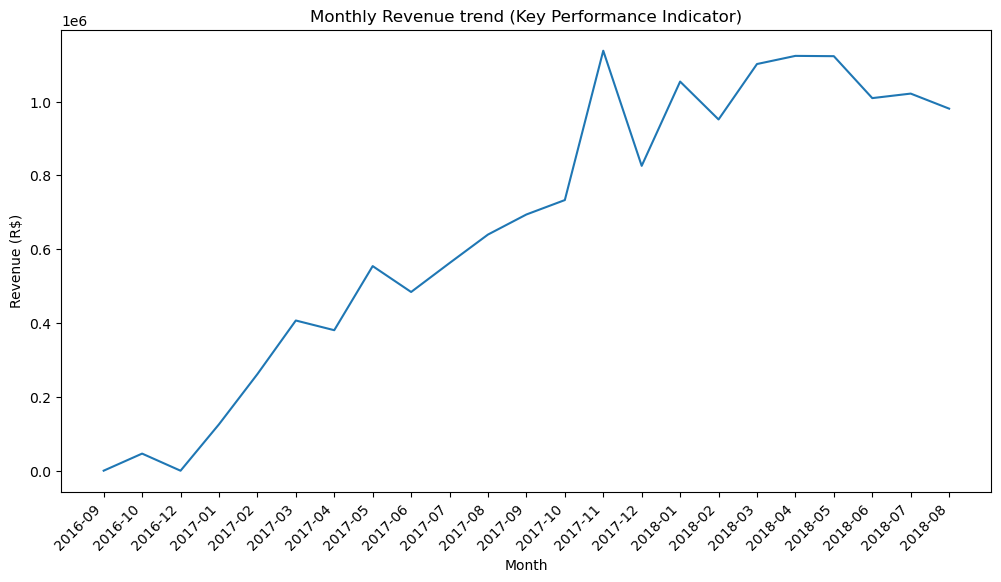

In [5]:
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_data, x='order_year_month', y='monthly_revenue')
plt.title("Monthly Revenue trend (Key Performance Indicator)")
plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.xticks(rotation=45, ha='right')
plt.show()

Figure 1

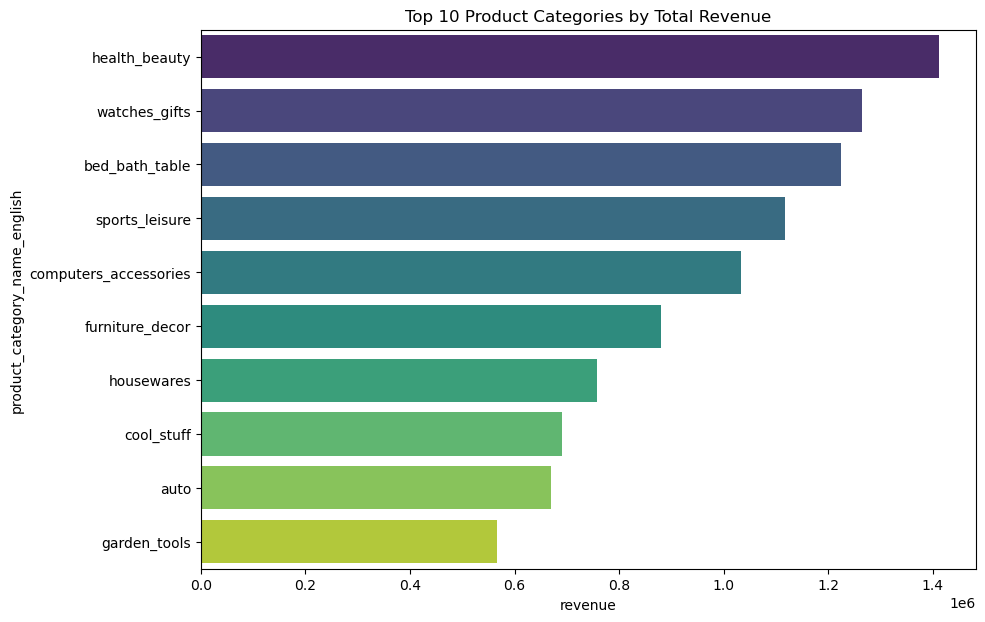

In [6]:
top_products = df.groupby('product_category_name_english')['revenue'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10,7))
sns.barplot(data=top_products, x='revenue', y='product_category_name_english', hue='product_category_name_english', palette='viridis', legend=False)
plt.title('Top 10 Product Categories by Total Revenue')
plt.show()

Figure 2

**Insights**:

Figure 1: 
* Strong initail growth: (Sept 2016 - Nov 2017)
* High volatility and seasonality peak.
* Revenue plateau. The business has hit a growth ceiling
* Recent Plateau: From May-2018 to Aug-2018 the revenue is failing below the R&1 million mark (Negative MoM growth)

Figure 2: 
* Health & Beauty is the domminat category, generating significantly more revenue ($\approx \text{R}\$1.45$ million) than any other category.
* Three Tiers:
    - Top Tier: health_beauty, watches_gifts, bed_bath_table (R$1.2M-R$1.45M)
    - Mid Tier: sports_leisure, computers_accessories, furniture_decor (R$0.85M - R$1.1M)
    - Bottom Tier: housewares, cool_stuff, auto, garden_tools (R$0.6M - R$0.75M)


### Customer Segmmentation (RFM Analysis)

In [7]:
present_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

In [8]:
rfm = df.groupby('customer_unique_id').agg(
    #Days since last purchase
    recency=('order_purchase_timestamp', lambda x: (present_date - x.max()).days),
    #Total number of unique orders
    frequency=('order_id', 'nunique'),
    #Total revenue
    monetary=('revenue', 'sum')
    ).reset_index()

print(rfm.head())

                 customer_unique_id  recency  frequency  monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89


* **Recency** Days since the customer's last purchase (Lowest Days are Better)
* **Frequency** Total number of unique orders/transactions made by the customer (Higher Count is Better)
* **Monetary** Total revenue (spending) generated by the customer (Higher Spend is Better)



### Segment Customers

In [9]:
rfm['R_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

def rfm_segment(score):
    # Tier 1: Top Customers
    if score in ['444', '443', '434', '344']: return '01 Champions'
    if score in ['441', '431', '331']: return '02 Loyal Customers'
    
    # Tier 2: Acquisition/Early Stage
    if score.startswith('4') and score.endswith('11'): return '03 New Customers' # R=4, F/M=1
    
    # Tier 3: Customers to be Saved
    if score.startswith('1') and score.endswith('4'): return '04 At Risk' # Lost R, but high M/F previously
    if score.startswith('2') and score.endswith('4'): return '05 Potential Loyalists' # Avg R, high M/F
    
    # Tier 4: Low Value/Low Engagement
    if score.startswith('111'): return '06 Lost'
    
    # Catch-all for other combinations (e.g., 222, 321, 131)
    return '07 Other'

rfm['Segment'] = rfm['RFM_Score'].apply(rfm_segment)
print(rfm['Segment'].value_counts())

Segment
07 Other                  67332
01 Champions               6289
05 Potential Loyalists     5687
04 At Risk                 5597
02 Loyal Customers         4277
06 Lost                    1485
03 New Customers           1412
Name: count, dtype: int64


* Recency is give a score from (1-4) 4 is highest score (lowest number of days since last purchase ) 1 is lowest score (higher number of days since last purchase)

* Frequency is given socre from (1-4) 4 highest score (Highest score means more orders purchases). Lowest score means lowest orders purchased

* Monetary is also given score from (1-4) highest score means higher spending, lowest score means lowest spending customer.


A good RFM score is R-score of 4, F-score of 4, M-score of 4 (444)

### Analyzing Marketing Channel Performance

**IMPORTANT DATA LIMITATION:**
The Olist dataset does not contain direct marketing attribution data (e.g., 'Google Ad', 'Email', 'Social Media'). Therefore, we must use a **proxy variable** to analyze channel performance.

Proxy Definition
* **Ideal Metric (Missing):** Marketing Channel / Source
* **Proxy Used (Available):** **Product Category Name (English)**
* **Justification:** We assume that customers seeking different product categories (e.g., 'health_beauty' vs. 'computers_accessories') represent distinct segments with varying transactional values and acquisition behaviors. This analysis identifies our most valuable *product segments* as a stand-in for our most valuable *customer acquisition channels*.

In [16]:
channel_metrics = df.groupby('product_category_name_english').agg(
    customers_acquired=('customer_unique_id', 'nunique'),
    total_revenue=('revenue', 'sum'),
    AOV=('revenue', 'mean')
).reset_index()

channel_metrics.head(10)



,product_category_name_english,customers_acquired,total_revenue,AOV
0,agro_industry_and_commerce,176,76203.30,369.918932
1,air_conditioning,244,59854.55,207.109170
2,art,195,27485.53,139.520457
3,arts_and_craftmanship,21,2184.14,91.005833
4,audio,347,56255.32,155.401436
5,auto,3769,669454.75,161.704046
6,baby,2783,466727.65,156.514973
7,bed_bath_table,9008,1225209.26,111.860610
8,books_general_interest,490,54182.54,100.898585
9,books_imported,49,5150.94,90.367368


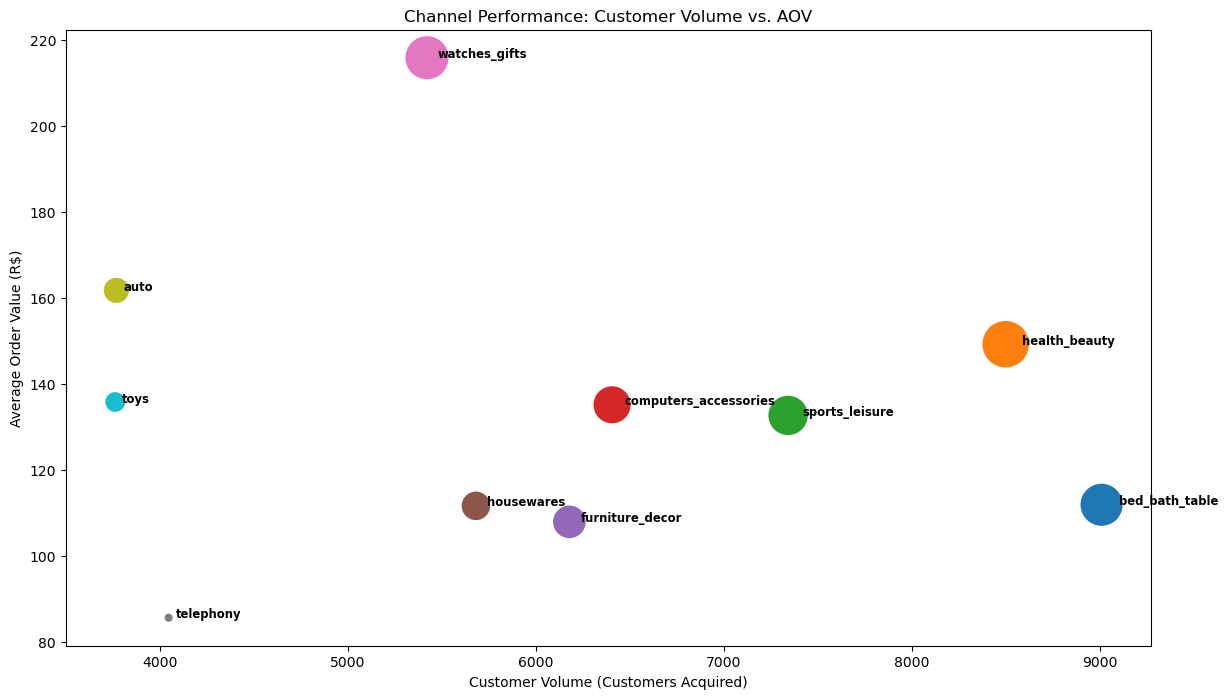

In [11]:

top_channels = channel_metrics.nlargest(10, 'customers_acquired')

plt.figure(figsize=(14, 8)) 
ax = sns.scatterplot(
    data=top_channels, 
    x='customers_acquired', 
    y='AOV', 
    hue='product_category_name_english',
    size='total_revenue',
    sizes=(50, 1200),
    legend=False 
)

for line in range(0, top_channels.shape[0]):
     ax.text(
         top_channels['customers_acquired'].iloc[line] * 1.01, 
         top_channels['AOV'].iloc[line],                    
         top_channels['product_category_name_english'].iloc[line], 
         horizontalalignment='left', 
         size='small', 
         color='black', 
         weight='semibold'
     )

plt.title('Channel Performance: Customer Volume vs. AOV')
plt.xlabel('Customer Volume (Customers Acquired)')
plt.ylabel('Average Order Value (R$)')
plt.show()

### Retention & Cohort Analysis

1.Define Cohorts 

In [12]:
df["cohort_month"] = df.groupby("customer_unique_id")["order_purchase_timestamp"] \
.transform('min') \
.dt.to_period('M')

df['purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M')

df['cohort_index'] = (df['purchase_month'] - df['cohort_month']).apply(lambda x: x.n)

cohort_sizes = df.groupby('cohort_month')['customer_unique_id'].nunique()


2.Track Retention

In [13]:
cohort_pivot = df.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()

retention_pivot = cohort_pivot.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='customer_unique_id'
)

retention_rate = retention_pivot.div(retention_pivot[0], axis=0)
retention_rate = (retention_rate * 100).round(2)

print("\n--- Cohort Retention Table (%) ---")
print(retention_rate)



--- Cohort Retention Table (%) ---
cohort_index     0       1     2     3     4     5     6     7     8     9   \
cohort_month                                                                  
2016-09       100.0     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2016-10       100.0     NaN   NaN   NaN   NaN   NaN  0.38   NaN   NaN  0.38   
2016-12       100.0  100.00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2017-01       100.0    0.28  0.28  0.14  0.42  0.14  0.42  0.14   NaN   NaN   
2017-02       100.0    0.19  0.32  0.06  0.44  0.13  0.25  0.19  0.13  0.19   
2017-03       100.0    0.45  0.37  0.37  0.37  0.16  0.16  0.33  0.33  0.08   
2017-04       100.0    0.64  0.23  0.18  0.27  0.27  0.32  0.32  0.32  0.18   
2017-05       100.0    0.47  0.44  0.30  0.30  0.33  0.41  0.15  0.24  0.24   
2017-06       100.0    0.50  0.37  0.44  0.30  0.40  0.33  0.23  0.13  0.17   
2017-07       100.0    0.54  0.32  0.24  0.27  0.22  0.32  0.11  0.19  0.27   
2017-08       10

3.Visualize Retention

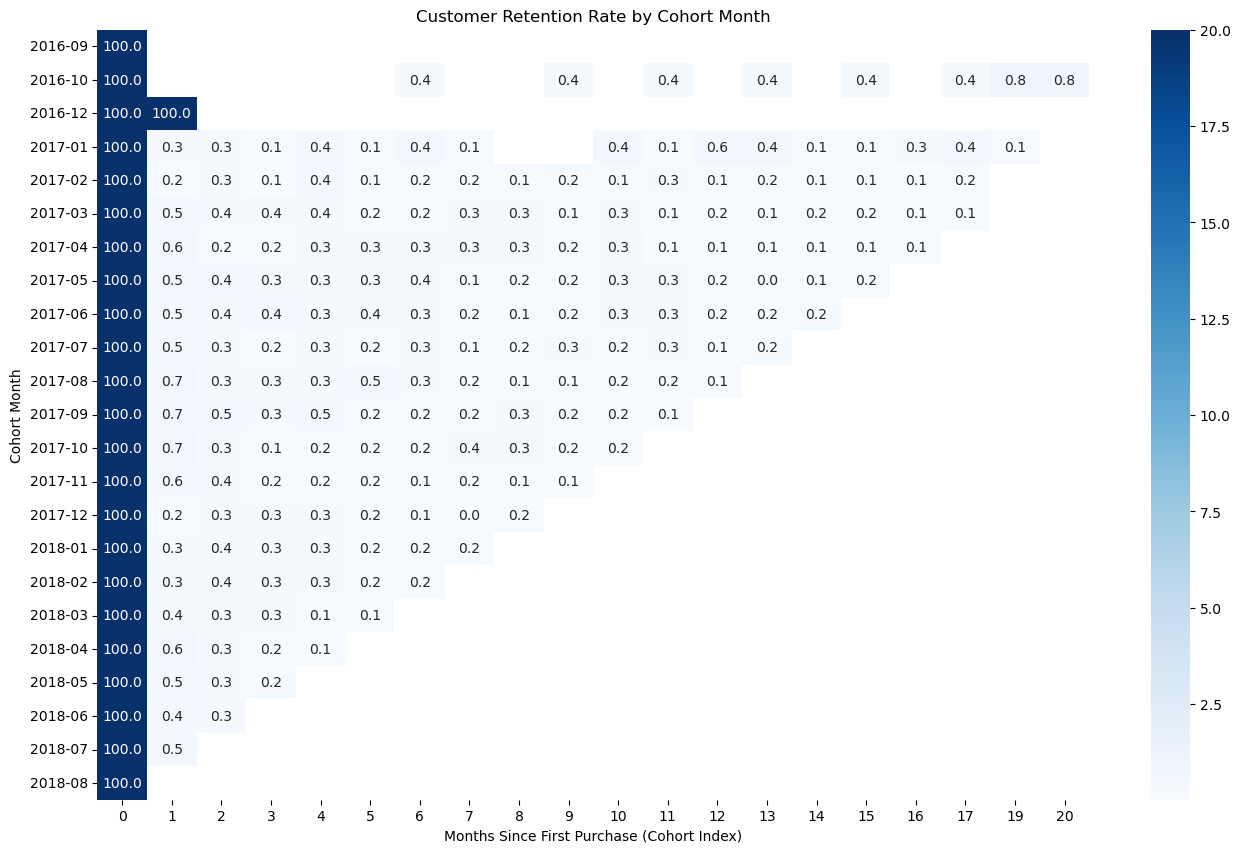

In [14]:
plt.figure(figsize=(16,10))
sns.heatmap(retention_rate,
annot=True,
fmt='.1f',
cmap='Blues',
vmax=20,
yticklabels=retention_rate.index.strftime('%Y-%m'))

plt.title('Customer Retention Rate by Cohort Month')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.show()

* **Retention Rate:** is extremmely low. Is between 0.3% and 0.7%. The business relies almost entirely on continuous acquisition, not loyalty. 

* **Retention Drops off Immediately:** The customer experience (product quality, delivery speed, customer serivce) following the first purchase is not strong enough to drive a second purchase. 

* **No Improvement:** Compare 2017 cohorts to 2018 cohorts, their retention curves are identical. This also tells us any initiatives (better service, better product) implemented between those years did not help with customer retention rates. 


4. Calculate Customer Lifetime Value (LTV)

In [15]:
repeat_buyers = rfm[rfm['frequency'] > 1]

customer_lifespan_days = df.groupby('customer_unique_id')['order_purchase_timestamp'].agg(
    lifespan=lambda x: (x.max() - x.min()).days
).mean()['lifespan']

data_years = (df['order_purchase_timestamp'].max() - df['order_purchase_timestamp'].min()).days / 365.25

avg_frequency_per_customer = df.groupby('customer_unique_id')['order_id'].nunique().mean()

LTV_simple = aov * avg_frequency_per_customer * (customer_lifespan_days / 365.25)
LTV_realistic = aov * avg_frequency_per_customer 


print(f"\nAverage Customer Lifespan (Proxy): {customer_lifespan_days:.0f} days")
print(f"Average Frequency (Per Customer, Total Period): {avg_frequency_per_customer:.2f} transactions")
print(f"Average LTV (Simple Calculation): R${LTV_simple:,.2f}")
print(f"Average LTV (Realistic Calculation): R${LTV_simple:,.2f}")



Average Customer Lifespan (Proxy): 3 days
Average Frequency (Per Customer, Total Period): 1.03 transactions
Average LTV (Simple Calculation): R$1.18
Average LTV (Realistic Calculation): R$1.18


* **Average Order Value (AOV):** R$160 (revenue per single order)
* **Average Frequency:** 1.03 transactions
* **Avg customer Lifespan:** 3 days (a data flaw. This low number is artificially skewed by the $\approx 99\%$ of one-time buyers (Lifespan = 0 days))

* **The Flawed Simple LTV Calculation:** the classic LTV formula is unreliable here becuase the Lifespan proxy (3 days) is near-zero, drastically shrinking the overall result. 

* **The Realistic LTV Estimate:** The most accurate representation of LTV is simple the total revenue generated by the average customer across the observed period (AOV X Average frequency)



### Final Business Recommendation

* **Overall Business Health:** The business has achieved revenue stability around R$1.0M a month but is not growing.

* **The Problem:** The  Realistic LTV of R$164.80 means the company cannot afford to spend much more than R$50-R$60 on acquiring a new customer (keeping CAC below $1/3$ of LTV).

* **The Recommendation:** The primary strategic focus must shift from acquisition (high volume, low loyalty) to retention. The goal is to move the Average Frequency from $1.03$ toward $1.5$ or $2.0$ to unlock sustainable LTV growth.

* Focuse on High-LTV Segmments, target Chammpions and At-Risk customers with exclusive campaigns. 

* Incentivize Second Purchase: Develop a high value cammpaign to target New Custmmers within their first 30 days. 

* Leverage Product Value: Invest in increasing satisfaction and repeat purchases within the Health_Beauty category. That category is the revenue foundation, and it offerss best chance for increasing Frequency. 